In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import numpy as np
import random
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("Energy_data.csv")

# Convert 'SendDate' to datetime and extract features
df['SendDate'] = pd.to_datetime(df['SendDate'])
df['Hour'] = df['SendDate'].dt.hour
df['Day'] = df['SendDate'].dt.day
df['Month'] = df['SendDate'].dt.month

# Create a feature for 'is_daytime' (1 = day, 0 = night)
df['is_daytime'] = df['Hour'].apply(lambda x: 1 if 6 <= x <= 18 else 0)

# Define input and output columns
X = df[['Hour', 'Day', 'Month', 'is_daytime']]
y = df[['Solar Power (kW)', 'consumptionValue (kW)', 'price']]

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train the XGBoost model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Validate the model
val_preds = model.predict(X_val_scaled)

In [2]:
# Calculate RMSE for validation set
rmse_values = {
    'Solar Power (kW)': np.sqrt(mean_squared_error(y_val['Solar Power (kW)'], val_preds[:, 0])),
    'Consumption Value (kW)': np.sqrt(mean_squared_error(y_val['consumptionValue (kW)'], val_preds[:, 1])),
    'Price': np.sqrt(mean_squared_error(y_val['price'], val_preds[:, 2]))
}

print(f"Validation RMSE Values: {rmse_values}")

Validation RMSE Values: {'Solar Power (kW)': np.float64(53.232295189543734), 'Consumption Value (kW)': np.float64(0.058078314220126166), 'Price': np.float64(1.8037386736902872)}


In [3]:
# Calculate RMSE for validation set
rmse_values = {
    'Solar Power (kW)': np.sqrt(mean_squared_error(y_val['Solar Power (kW)'], val_preds[:, 0])),
    'Consumption Value (kW)': np.sqrt(mean_squared_error(y_val['consumptionValue (kW)'], val_preds[:, 1])),
    'Price': np.sqrt(mean_squared_error(y_val['price'], val_preds[:, 2]))
}

print(f"Validation RMSE Values: {rmse_values}")

Validation RMSE Values: {'Solar Power (kW)': np.float64(53.232295189543734), 'Consumption Value (kW)': np.float64(0.058078314220126166), 'Price': np.float64(1.8037386736902872)}


In [4]:
import random

def predict_new_data(send_date_str):
    # Convert the user input to datetime and extract features
    input_df = pd.DataFrame([send_date_str], columns=['SendDate'])
    input_df['SendDate'] = pd.to_datetime(input_df['SendDate'])
    input_df['Hour'] = input_df['SendDate'].dt.hour
    input_df['Day'] = input_df['SendDate'].dt.day
    input_df['Month'] = input_df['SendDate'].dt.month
    
    # Determine if it's daytime or nighttime
    input_df['is_daytime'] = input_df['Hour'].apply(lambda x: 1 if 6 <= x < 18 else 0)
    
    # Preprocess the input
    input_scaled = scaler.transform(input_df[['Hour', 'Day', 'Month', 'is_daytime']])
    
    # Predict using the trained model
    prediction = model.predict(input_scaled)
    
    # Set solar power to a random value between 1 and 150 if it’s nighttime
    if input_df['is_daytime'].iloc[0] == 0:
        prediction[0][0] = random.uniform(0, 150)  
    
    return prediction

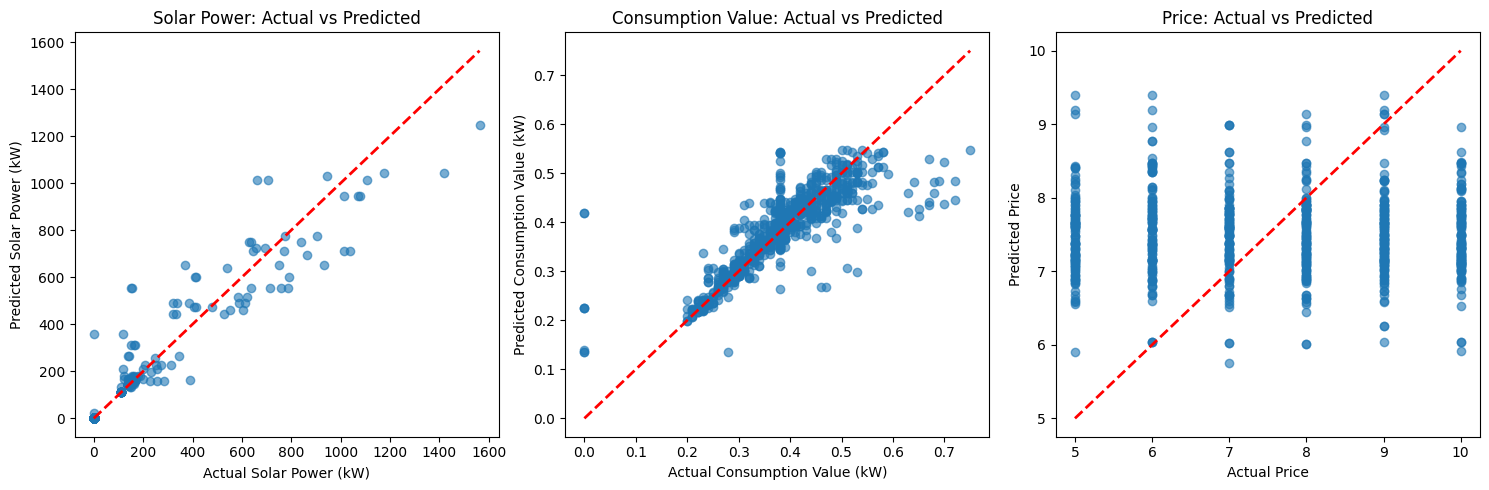

In [5]:
# Plotting the actual vs predicted values for validation set
def plot_validation_results(y_val, val_preds):
    plt.figure(figsize=(15, 5))

    # Solar Power (kW)
    plt.subplot(1, 3, 1)
    plt.scatter(y_val['Solar Power (kW)'], val_preds[:, 0], alpha=0.6)
    plt.plot([y_val['Solar Power (kW)'].min(), y_val['Solar Power (kW)'].max()],
             [y_val['Solar Power (kW)'].min(), y_val['Solar Power (kW)'].max()],
             'r--', lw=2)
    plt.title('Solar Power: Actual vs Predicted')
    plt.xlabel('Actual Solar Power (kW)')
    plt.ylabel('Predicted Solar Power (kW)')

    # Consumption Value (kW)
    plt.subplot(1, 3, 2)
    plt.scatter(y_val['consumptionValue (kW)'], val_preds[:, 1], alpha=0.6)
    plt.plot([y_val['consumptionValue (kW)'].min(), y_val['consumptionValue (kW)'].max()],
             [y_val['consumptionValue (kW)'].min(), y_val['consumptionValue (kW)'].max()],
             'r--', lw=2)
    plt.title('Consumption Value: Actual vs Predicted')
    plt.xlabel('Actual Consumption Value (kW)')
    plt.ylabel('Predicted Consumption Value (kW)')

    # Price
    plt.subplot(1, 3, 3)
    plt.scatter(y_val['price'], val_preds[:, 2], alpha=0.6)
    plt.plot([y_val['price'].min(), y_val['price'].max()],
             [y_val['price'].min(), y_val['price'].max()],
             'r--', lw=2)
    plt.title('Price: Actual vs Predicted')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_validation_results(y_val, val_preds)

In [6]:
# User input loop
while True:
    user_input = input("Enter a datetime (format: 'YYYY-MM-DD HH:MM') or 'exit' to quit: ")
    
    if user_input.lower() == 'exit':
        break
    
    try:
        # Predict based on user input
        predicted_values = predict_new_data(user_input)
        print(f"Predicted Solar Power (kW): {predicted_values[0][0]:.2f}, "
              f"Consumption Value (kW): {predicted_values[0][1]:.2f}, "
              f"Price: {predicted_values[0][2]:.2f}")
    except Exception as e:
        print(f"Error: {e}. Please enter a valid datetime in 'YYYY-MM-DD HH:MM' format.")


Predicted Solar Power (kW): 638.57, Consumption Value (kW): 0.42, Price: 7.34
Predicted Solar Power (kW): 24.87, Consumption Value (kW): 0.43, Price: 8.96
Predicted Solar Power (kW): 825.15, Consumption Value (kW): 0.49, Price: 7.41
Predicted Solar Power (kW): 825.15, Consumption Value (kW): 0.49, Price: 7.41
Predicted Solar Power (kW): 825.15, Consumption Value (kW): 0.49, Price: 7.41
Predicted Solar Power (kW): 825.15, Consumption Value (kW): 0.49, Price: 7.41


In [7]:
import joblib
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']